# BP Prediction and ABP Estimation End-to-End Pipelines

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [ ]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: Tesla T4
GPU Capability: (7, 5)
Is GPU Initialized yet? True


# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/GDrive')

Drive already mounted at /content/GDrive; to attempt to forcibly remount, call drive.mount("/content/GDrive", force_remount=True).


Move to the Target Directory

In [ ]:
%cd /content/GDrive/MyDrive/Colab_Notebooks/Research/PPG2ABP 

/content/GDrive/MyDrive/Colab_Notebooks/Research/PPG2ABP


List the Files and Folders Located in the Current Directory

In [ ]:
!ls

AlbuNet_1DCNN.py		    Prepare_Train_Dictionary.py
BCG_Patient_Wise_Data		    __pycache__
data_handling.py		    Ranked_Features.h5
data_processing.py		    ReadingSakib5.txt
delete_short_extra_est.py	    README.md
evaluate.py			    ResNet_1DCNN.py
Evaluation_Metrics_ABP.py	    Res_Unet_1DCNN.py
Evaluation_Metrics_BP.py	    Synthetic_PPG.h5
Feature_Selection_Regression.ipynb  TernausNet_1DCNN.py
helper_functions.py		    Test_Dataset_BCG.h5
imports_est.py			    Test_Dataset_BCG_TL.h5
metrics.py			    Test_Dataset.h5
ml_models.py			    Train_Dataset_BCG.h5
models_est.py			    Train_Dataset.h5
models.py			    Train_Dataset_UCI_TL.h5
organize_patients_est.py	    Trained_Models
PAVE2ABP_GitHub.ipynb		    train_models.py
PAVE2ABP.ipynb			    UCI_BCG_Splitted_Data_3CH.h5
PAVE2ABP_UCI_BCG_2.ipynb	    UCI_BCG_Splitted_Data_4CH.h5
PAVE2ABP_UCI_BCG_3.ipynb	    UCI_Splitted_Data_1CH.h5
PAVE2ABP_UCI_BCG.ipynb		    UCI_Splitted_Data_2CH.h5
PPG2ABP_UCI.ipynb		    UCI_Splitted_Data_3CH.h5
PPGSensorData.t

## Evaluation of Predicting ABP Waveforms

Here, we present an interactive CLI to predict the ABP waveform from PPG signal from the test data. Ground truth, prediction from approximation network and refinement network are presented, and a comparison is also demonstrated


#Import Libraries

In [ ]:
import os
import h5py
import scipy
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm

In [ ]:
from ml_models import *
from Evaluation_Metrics_BP import *
from Evaluation_Metrics_ABP import *
from UNet_1DCNN import UNet
from TernausNet_1DCNN import TernausNet
from AlbuNet_1DCNN import AlbuNet

In [ ]:
%matplotlib inline
sns.set_style('white')

# Set Number of Channels

In [ ]:
num_channel = 4

# Import and Prepare Data

Note: Data pre-processing was mainly conducted in MATLAB. Here, data was loaded from the GDrive and prepared for Deep Learning

### Import Dataset for Train and Test on UCI

In [ ]:
fl_Train = h5py.File(os.path.join('Train_Dataset.h5'), 'r')      # load the episode data
fl_Train['PPG'].shape

(147116, 1024)

In [ ]:
fl_Test = h5py.File(os.path.join('Test_Dataset.h5'), 'r')        # load the episode data
fl_Test['PPG'].shape

(53043, 1024)

### Prepare Train Data


In [ ]:
# intialize train data
length = 1024
X_Train = []
Y_Train_BP = []
Y_Train_ABP = []

if num_channel == 1:

    for i in tqdm(range(0, fl_Train['PPG'].shape[0]), desc='Preparing Train Data'):
        X_Train.append(np.array(fl_Train['PPG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train['ABP_RNorm'][i][:length]).reshape(length, 1))


    X_Train = np.array(X_Train)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    Y_Train_ABP.shape

elif num_channel == 2:
    PPG = []
    ECG = []

    for i in tqdm(range(0, fl_Train['PPG'].shape[0]), desc='Preparing Train Data'):
        PPG.append(np.array(fl_Train['PPG'][i][:length]).reshape(length, 1))
        ECG.append(np.array(fl_Train['ECG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    ECG = np.array(ECG)
    X_Train = np.stack((PPG, ECG), axis=2)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    Y_Train_ABP.shape

elif num_channel == 3:
    PPG = []
    VPG = []
    APG = []

    for i in tqdm(range(0, fl_Train['PPG'].shape[0]), desc='Preparing Train Data'):
        PPG.append(np.array(fl_Train['PPG'][i][:length]).reshape(length, 1))
        VPG.append(np.array(fl_Train['VPG'][i][:length]).reshape(length, 1))
        APG.append(np.array(fl_Train['APG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    X_Train = np.stack((PPG, VPG, APG), axis=2)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    Y_Train_ABP.shape

elif num_channel == 4:
    PPG = []
    VPG = []
    APG = []
    ECG = []

    for i in tqdm(range(0, fl_Train['PPG'].shape[0]), desc='Preparing Train Data'):
        PPG.append(np.array(fl_Train['PPG'][i][:length]).reshape(length, 1))
        VPG.append(np.array(fl_Train['VPG'][i][:length]).reshape(length, 1))
        APG.append(np.array(fl_Train['APG'][i][:length]).reshape(length, 1))
        ECG.append(np.array(fl_Train['ECG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.squeeze(np.array(PPG), axis=2)
    VPG = np.squeeze(np.array(VPG), axis=2)
    APG = np.squeeze(np.array(APG), axis=2)
    ECG = np.squeeze(np.array(ECG), axis=2)
    X_Train = np.stack((PPG, VPG, APG, ECG), axis=2)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    X_Train.shape

Preparing Train Data: 100%|██████████| 147116/147116 [04:33<00:00, 538.24it/s]


### Prepare Test Data

In [ ]:
# intialize test data
length = 1024
X_Test = []
Y_Test_BP = []
Y_Test_ABP = []

if num_channel == 1:

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        X_Test.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))    # ppg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    X_Test = np.array(X_Test)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape

elif num_channel == 2:
    PPG = []
    ECG = []

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        PPG.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))       # ppg signal
        ECG.append(np.array(fl_Test['ECG'][i][:length]).reshape(length, 1))       # ecg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    ECG = np.array(ECG)
    X_Test = np.stack((PPG, ECG), axis=2)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape

elif num_channel == 3:
    PPG = []
    VPG = []
    APG = []

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        PPG.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))       # ppg signal
        VPG.append(np.array(fl_Test['VPG'][i][:length]).reshape(length, 1))       # vpg signal
        APG.append(np.array(fl_Test['APG'][i][:length]).reshape(length, 1))       # apg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    X_Test = np.stack((PPG, VPG, APG), axis=2)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape

elif num_channel == 4:
    PPG = []
    VPG = []
    APG = []
    ECG = []

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        PPG.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))       # ppg signal
        VPG.append(np.array(fl_Test['VPG'][i][:length]).reshape(length, 1))       # vpg signal
        APG.append(np.array(fl_Test['APG'][i][:length]).reshape(length, 1))       # apg signal
        ECG.append(np.array(fl_Test['ECG'][i][:length]).reshape(length, 1))       # apg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    ECG = np.array(ECG)
    X_Test = np.stack((PPG, VPG, APG, ECG), axis=2)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape

Preparing Test Data: 100%|██████████| 53043/53043 [01:42<00:00, 515.09it/s]


### Extract SBP and DBP Label Data from the Training Set

In [ ]:
SBP_Train = []
DBP_Train = []

# SBP
for i in tqdm(range(0, fl_Train['SBP'].shape[0]), desc='Extracting Ground_Truth SBP from Training Set'):
    SBP_Train.append(np.array(fl_Train['SBP'][i][0]).reshape(1, 1)) 

SBP_Train = np.squeeze(np.array(SBP_Train),axis=2)

# DBP
for i in tqdm(range(0, fl_Train['DBP'].shape[0]), desc='Extracting Ground_Truth DBP from Training Set'):
    DBP_Train.append(np.array(fl_Train['DBP'][i][0]).reshape(1, 1)) 

DBP_Train = np.squeeze(np.array(DBP_Train),axis=2)
DBP_Train.shape

Extracting Ground_Truth DBP from Training Set: 100%|██████████| 147116/147116 [00:41<00:00, 3508.78it/s]


(147116, 1)

### Extract Ground Truth SBP and DBP from the Testing Set

In [ ]:
SBP_Test = []
DBP_Test = []

# SBP
for i in tqdm(range(0, fl_Test['SBP'].shape[0]), desc='Extracting Ground_Truth SBP from Testing Set'):
    SBP_Test.append(np.array(fl_Test['SBP'][i][0]).reshape(1, 1)) 

SBP_Test = np.squeeze(np.array(SBP_Test),axis=2)

# DBP
for i in tqdm(range(0, fl_Test['DBP'].shape[0]), desc='Extracting Ground_Truth DBP from Testing Set'):
    DBP_Test.append(np.array(fl_Test['DBP'][i][0]).reshape(1, 1)) 

DBP_Test = np.squeeze(np.array(DBP_Test),axis=2)
DBP_Test.shape

Extracting Ground_Truth DBP from Testing Set: 100%|██████████| 53043/53043 [00:15<00:00, 3506.97it/s]


(53043, 1)

### Prepare ABP Ground Truth for PPG2ABP

In [ ]:
ABP_GRND = []

for i in tqdm(range(0, fl_Test['ABP_GRND'].shape[0]), desc='Extracting Ground_Truth'):
    ABP_GRND.append(np.array(fl_Test['ABP_GRND'][i][:length]).reshape(length, 1)) 

ABP_GRND = np.array(ABP_GRND)
ABP_GRND.shape

Extracting Ground_Truth: 100%|██████████| 53043/53043 [00:17<00:00, 3104.74it/s]


(53043, 1024, 1)

### Train-Val Split [Test Data is Completely Independent]

In [ ]:
X_Train1, X_Val1, Y_Train1, Y_Val1, Y_Train2, Y_Val2, SBP_Train1, SBP_Val1, DBP_Train1, DBP_Val1 = train_test_split(X_Train, Y_Train_BP, Y_Train_ABP, SBP_Train, DBP_Train, test_size=0.2, random_state=42)

In [ ]:
X_Test1 = X_Test
Y_Test1 = Y_Test_BP
Y_Test2 = Y_Test_ABP

### Garbage Collector

In [ ]:
import gc #Garbage Collector
fl_Train = None
fl_Test = None
X_Test = None
X_Train = None
X_Val = None
SBP_Train = None
DBP_Train = None
gc.collect()

309

# BP Prediction

## Build and Train Autoencoder

Configurations

In [ ]:
# Configurations
feature_number = 1024
signal_length = 1024
PPG2BP_model_depth = 1
PPG2BP_model_width = 128
kernel_size_PPG2BP = 3
D_S = 0
A_E = 1
model_name = 'UNet'

In [ ]:
# Build model for PPG2BP - Shallow-Wide U-Net as AutoEncoder
PAVE2BP_Network = UNet(signal_length, PPG2BP_model_depth, num_channel, PPG2BP_model_width, kernel_size_PPG2BP, 'Regression', 1, D_S, A_E, feature_number).UNet()
PAVE2BP_Network.compile(optimizer='adam', loss='mae', metrics=['mse', 'accuracy'])

In [ ]:
PAVE2BP_Network.load_weights('Trained_Models/PAVE2BP_UCI_'+model_name+'_'+str(PPG2BP_model_depth)+'_'+str(PPG2BP_model_width)+'_'+str(kernel_size_PPG2BP)+'_'+str(num_channel)+'.h5')

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, mode='min'), 
             tf.keras.callbacks.ModelCheckpoint('Trained_Models/PAVE2BP_UCI_'+model_name+'_'+str(PPG2BP_model_depth)+'_'
             +str(PPG2BP_model_width)+'_'+str(kernel_size_PPG2BP)+'_'+str(num_channel)+'.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = PAVE2BP_Network.fit(X_Train1, Y_Train1, epochs= 200, batch_size= 128, verbose=1, validation_data= (X_Val1, Y_Val1), shuffle= True, callbacks= callbacks)

Epoch 1/200
920/920 [==============================] - 152s 144ms/step - loss: 0.0982 - mse: 0.0199 - accuracy: 3.3190e-08 - val_loss: 0.0903 - val_mse: 0.0139 - val_accuracy: 3.3189e-08

Epoch 00001: val_loss improved from inf to 0.09025, saving model to Trained_Models/PAVE2BP_UCI_UNet_1_128_3_4.h5
Epoch 2/200
920/920 [==============================] - 131s 142ms/step - loss: 0.0752 - mse: 0.0104 - accuracy: 3.3190e-08 - val_loss: 0.0749 - val_mse: 0.0100 - val_accuracy: 3.3189e-08

Epoch 00002: val_loss improved from 0.09025 to 0.07495, saving model to Trained_Models/PAVE2BP_UCI_UNet_1_128_3_4.h5
Epoch 3/200
920/920 [==============================] - 131s 142ms/step - loss: 0.0688 - mse: 0.0090 - accuracy: 3.3190e-08 - val_loss: 0.0750 - val_mse: 0.0103 - val_accuracy: 3.3189e-08

Epoch 00003: val_loss did not improve from 0.07495
Epoch 4/200
920/920 [==============================] - 131s 142ms/step - loss: 0.0655 - mse: 0.0082 - accuracy: 3.3190e-08 - val_loss: 0.0714 - val_mse: 0.

Plot History

dict_keys(['loss', 'mse', 'accuracy', 'val_loss', 'val_mse', 'val_accuracy'])


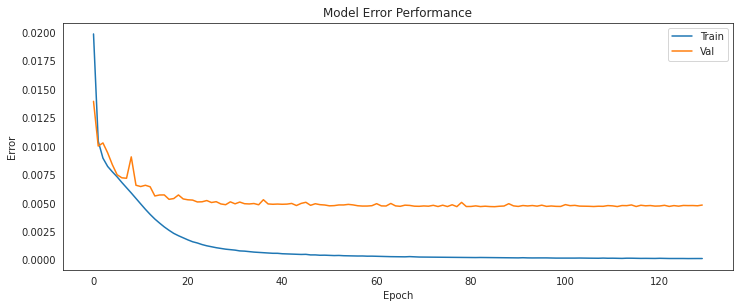

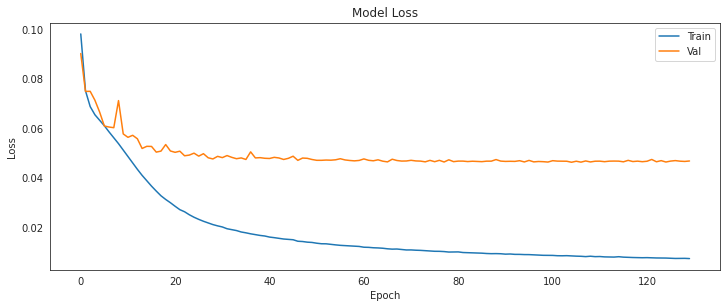

In [ ]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mse'])
  plt.plot(history.history['val_mse'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Extract Features from the Autoencoder

In [ ]:
Feature_Extractor = tf.keras.Model(inputs = PAVE2BP_Network.input, outputs = PAVE2BP_Network.get_layer('features').output)
Train_Features = Feature_Extractor.predict(X_Train1)
Test_Features = Feature_Extractor.predict(X_Test1)

Save Feature Matrices

In [ ]:
outfile = open('Trained_Models/Train_Features_PAVE2BP_' + str(num_channel) + '.p','wb')
pickle.dump(Train_Features, outfile)
outfile.close()
#
outfile = open('Trained_Models/Test_Features_PAVE2BP_' + str(num_channel) + '.p','wb')
pickle.dump(Test_Features, outfile)
outfile.close()

In [ ]:
print(Train_Features.shape)
print(Test_Features.shape)

(117692, 1024)
(53043, 1024)


Import Saved Features

In [ ]:
infile = open('Trained_Models/Train_Features_PAVE2BP_' + str(num_channel) + '.p','rb')
Train_Features = pickle.load(infile)
infile.close()
#
infile = open('Trained_Models/Test_Features_PAVE2BP_' + str(num_channel) + '.p','rb')
Test_Features = pickle.load(infile)
infile.close()

## Regression on Extracted Features

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Prediction from ML Algorithm
[Preds_SBP_PAVE2BP, Score_SBP_PAVE2BP] = mlp_regressor(Train_Features, Test_Features, SBP_Train1)
[Preds_DBP_PAVE2BP, Score_DBP_PAVE2BP] = mlp_regressor(Train_Features, Test_Features, DBP_Train1)
# Preds_SBP_PAVE2BP = Ensemble(Train_Features_2, Test_Features_2, SBP_Train1).random_forest_regressor()
# Preds_DBP_PAVE2BP = Ensemble(Train_Features_2, Test_Features_2, DBP_Train1).random_forest_regressor()

In [ ]:
outfile = open('Trained_Models/Preds_SBP_PAVE2BP_' + str(num_channel) + '.p','wb')
pickle.dump(Preds_SBP_PAVE2BP, outfile)
outfile.close()
#
outfile = open('Trained_Models/Preds_DBP_PAVE2BP_' + str(num_channel) + '.p','wb')
pickle.dump(Preds_DBP_PAVE2BP, outfile)
outfile.close()

In [ ]:
infile = open('Trained_Models/Preds_SBP_PAVE2BP_' + str(num_channel) + '.p','rb')
Preds_SBP_PAVE2BP = pickle.load(infile)
infile.close()
#
infile = open('Trained_Models/Preds_DBP_PAVE2BP_' + str(num_channel) + '.p','rb')
Preds_DBP_PAVE2BP = pickle.load(infile)
infile.close()

## Evaluate BP Prediction

Mean Absolute Error (MAE)

In [ ]:
# Evaluation of ML Algorithm Performance - Mean Absolute Error
MAE_SBP_PAVE2BP = mean_absolute_error(SBP_Test, Preds_SBP_PAVE2BP)
MAE_DBP_PAVE2BP = mean_absolute_error(DBP_Test, Preds_DBP_PAVE2BP)
print("Mean Absolute Error SBP_PAVE2BP: %f" % MAE_SBP_PAVE2BP)
print("Mean Absolute Error DBP_PAVE2BP: %f" % MAE_DBP_PAVE2BP)

Mean Absolute Error SBP_PAVE2BP: 2.127736
Mean Absolute Error DBP_PAVE2BP: 0.825333


In [ ]:
# Evaluation of ML Algorithm Performance - Mean Squared Error
MSE_SBP_PAVE2BP = mean_squared_error(SBP_Test, Preds_SBP_PAVE2BP)
MSE_DBP_PAVE2BP = mean_squared_error(DBP_Test, Preds_DBP_PAVE2BP)
print("Mean Squared Error SBP_PAVE2BP: %f" % MSE_SBP_PAVE2BP)
print("Mean Squared Error DBP_PAVE2BP: %f" % MSE_DBP_PAVE2BP)

Mean Squared Error SBP_PAVE2BP: 8.686325
Mean Squared Error DBP_PAVE2BP: 1.239403


BHS

------------------------------------------
|        BHS-Metric-BP Prediction        |
------------------------------------------
------------------------------------------
|       | <= 5mmHg | <=10mmHg | <=15mmHg |
------------------------------------------
|  DBP  |   99.84 %   |   99.99 %   |  100.0 %    |
|  SBP  |   92.32 %   |   99.07 %   |  99.87 %    |
------------------------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


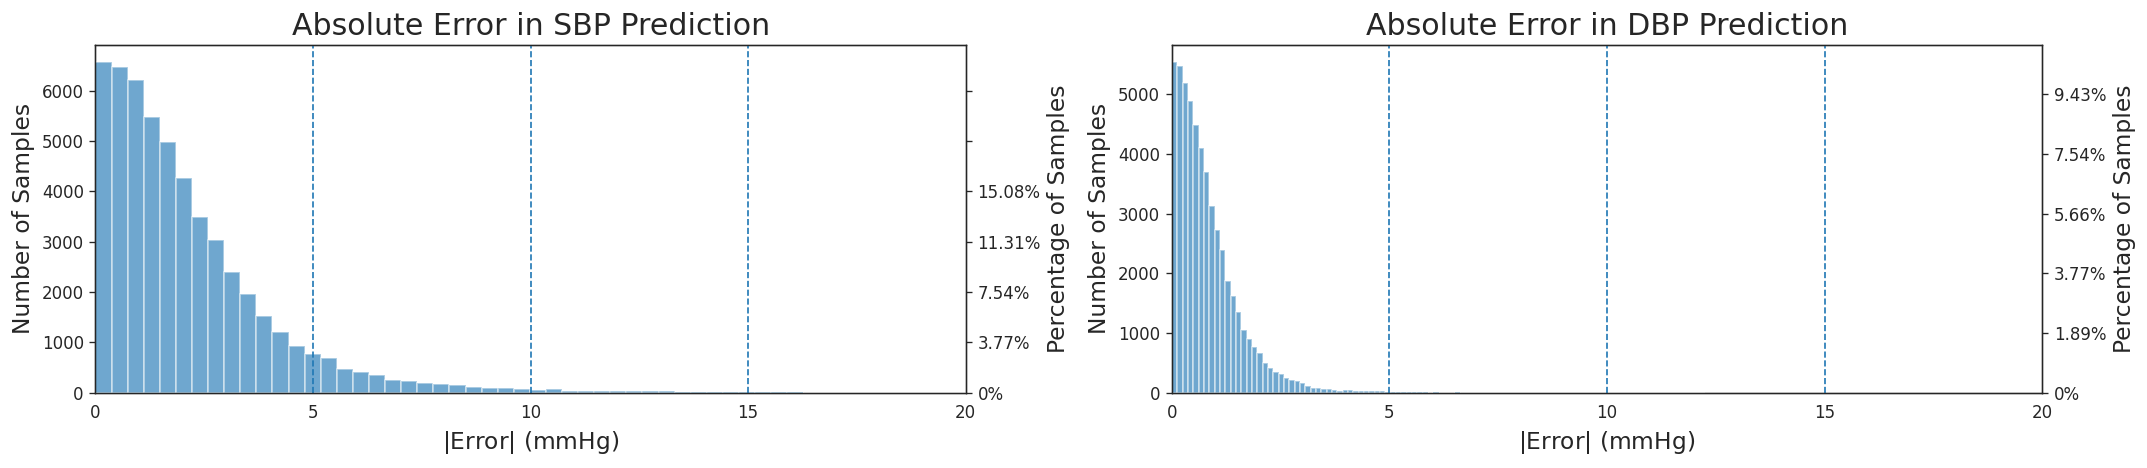

In [ ]:
BHS_Metric_BP(SBP_Test, Preds_SBP_PAVE2BP, DBP_Test, Preds_DBP_PAVE2BP)

AAMI

---------------------------------
| AAMI Standard - BP_Prediction |
---------------------------------
-----------------------
|     | ME | STD |     
-----------------------
| DBP | 0.342 |  1.059 |
| SBP | 0.248 |  2.937 |
-----------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


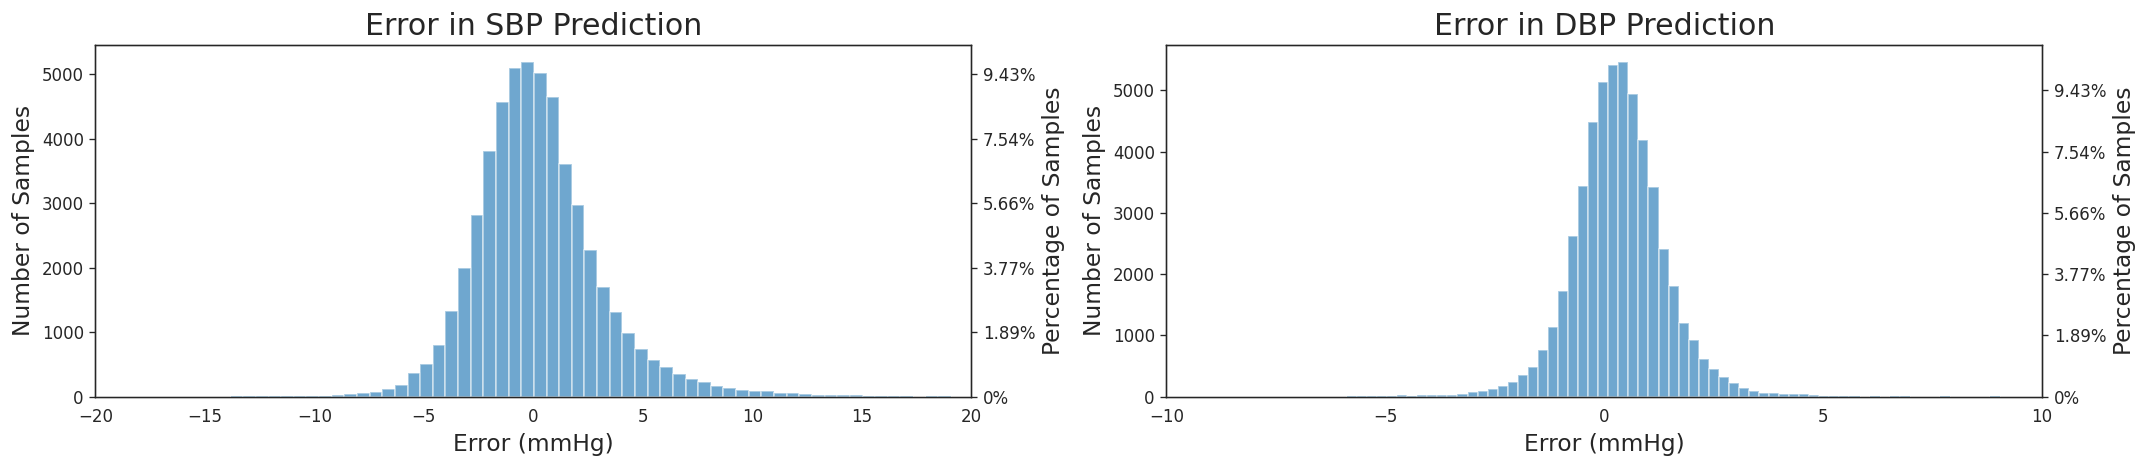

In [ ]:
calcErrorAAMI_BP(SBP_Test, Preds_SBP_PAVE2BP, DBP_Test, Preds_DBP_PAVE2BP)

BP Classificaiton

DBP Classification Accuracy
                  precision    recall  f1-score   support

    Hypertension    0.96384   0.94714   0.95542      1154
    Normotension    0.99171   0.99575   0.99373     48747
Pre-hypertension    0.90955   0.85773   0.88288      3142

        accuracy                        0.98652     53043
       macro avg    0.95503   0.93354   0.94401     53043
    weighted avg    0.98623   0.98652   0.98633     53043

SBP Classification Accuracy
                 precision    recall  f1-score   support

   Hypertension    0.95048   0.95191   0.95120     19277
   Normotension    0.95438   0.93436   0.94426     15022
Prehypertension    0.89947   0.91320   0.90628     18744

       accuracy                        0.93326     53043
      macro avg    0.93478   0.93316   0.93391     53043
   weighted avg    0.93356   0.93326   0.93336     53043



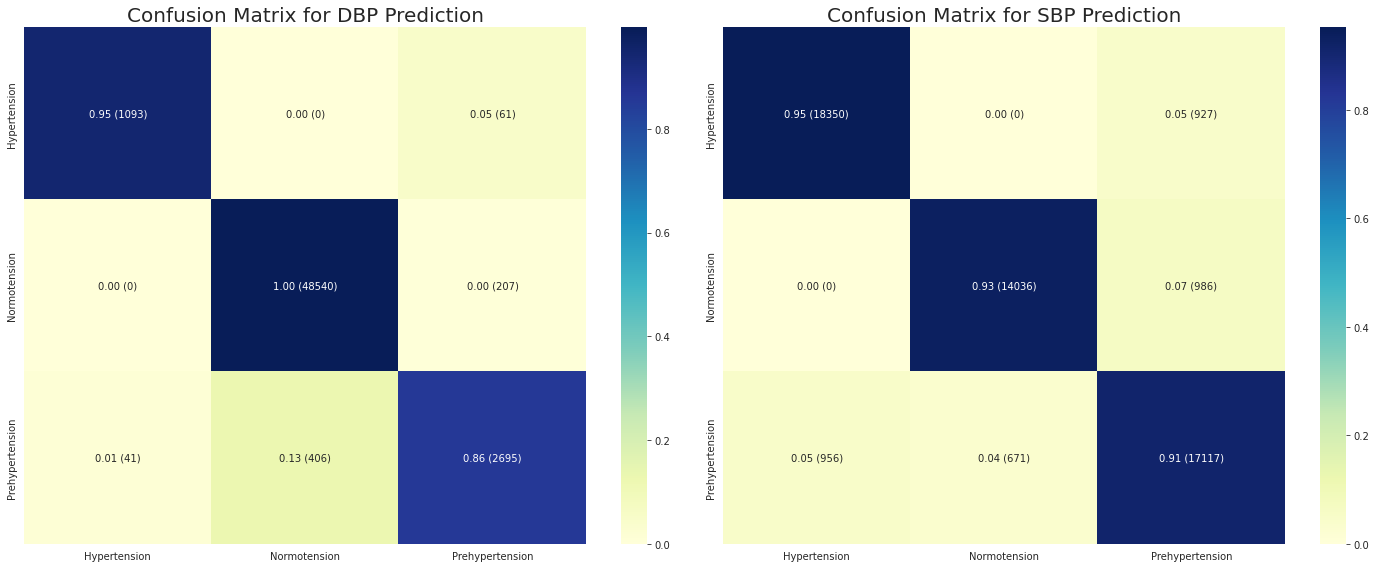

In [ ]:
evaluate_BP_Classification_BP(SBP_Test, DBP_Test, Preds_SBP_PAVE2BP, Preds_DBP_PAVE2BP)

Regression Plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


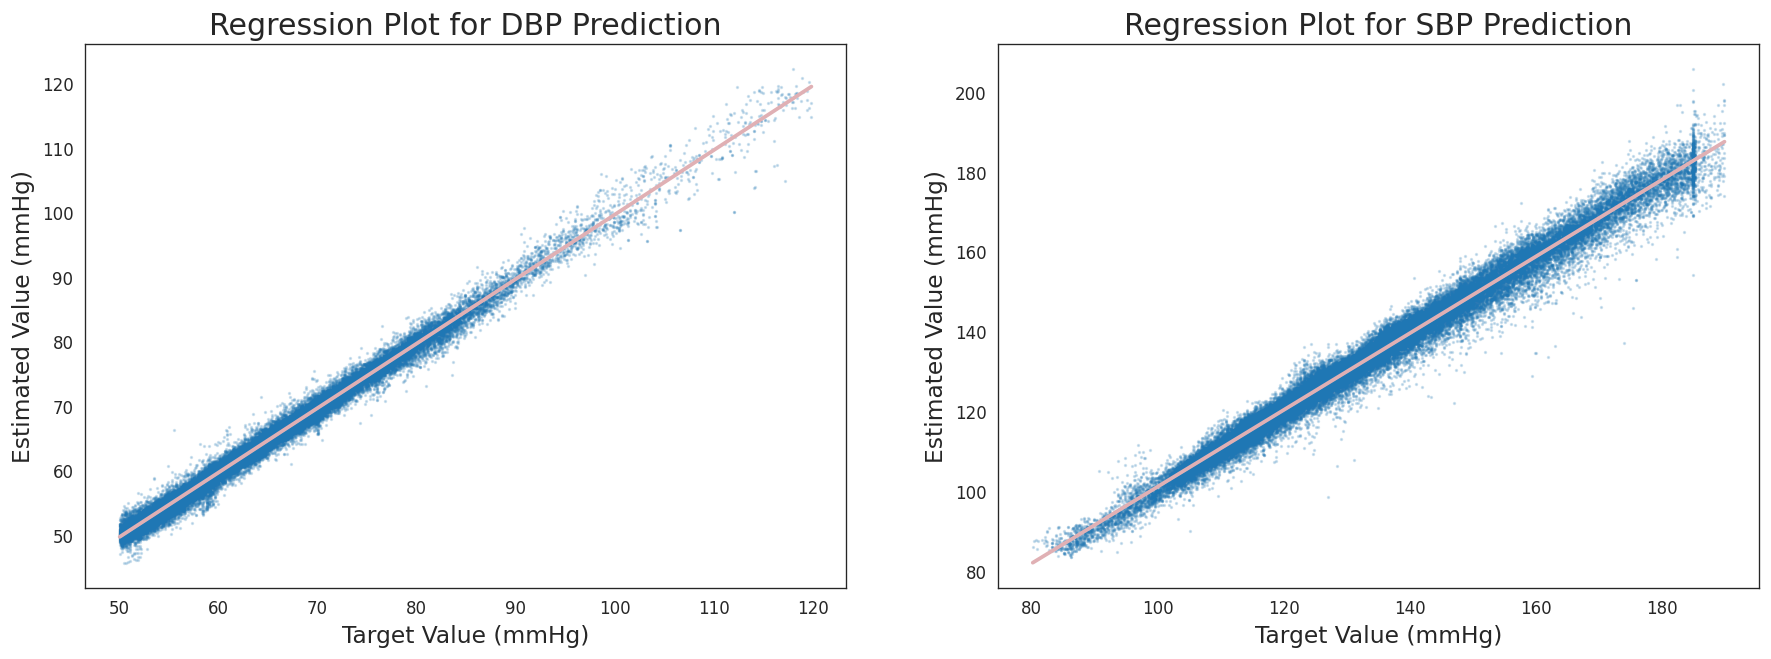

DBP
LinregressResult(slope=0.9997847457175235, intercept=-0.32822482845162426, rvalue=0.9946707977209689, pvalue=0.0, stderr=0.0004499746045617885)
SBP
LinregressResult(slope=0.9605711878807827, intercept=5.0458769068592915, rvalue=0.9908130740169595, pvalue=0.0, stderr=0.0005692883893371327)


In [ ]:
regression_plot_BP(SBP_Test, DBP_Test, Preds_SBP_PAVE2BP, Preds_DBP_PAVE2BP)

Bland Altman Plots

---------DBP---------
2.418602552812646 -1.7341858941568016
---------SBP---------
6.004296386105923 -5.5079139865510465


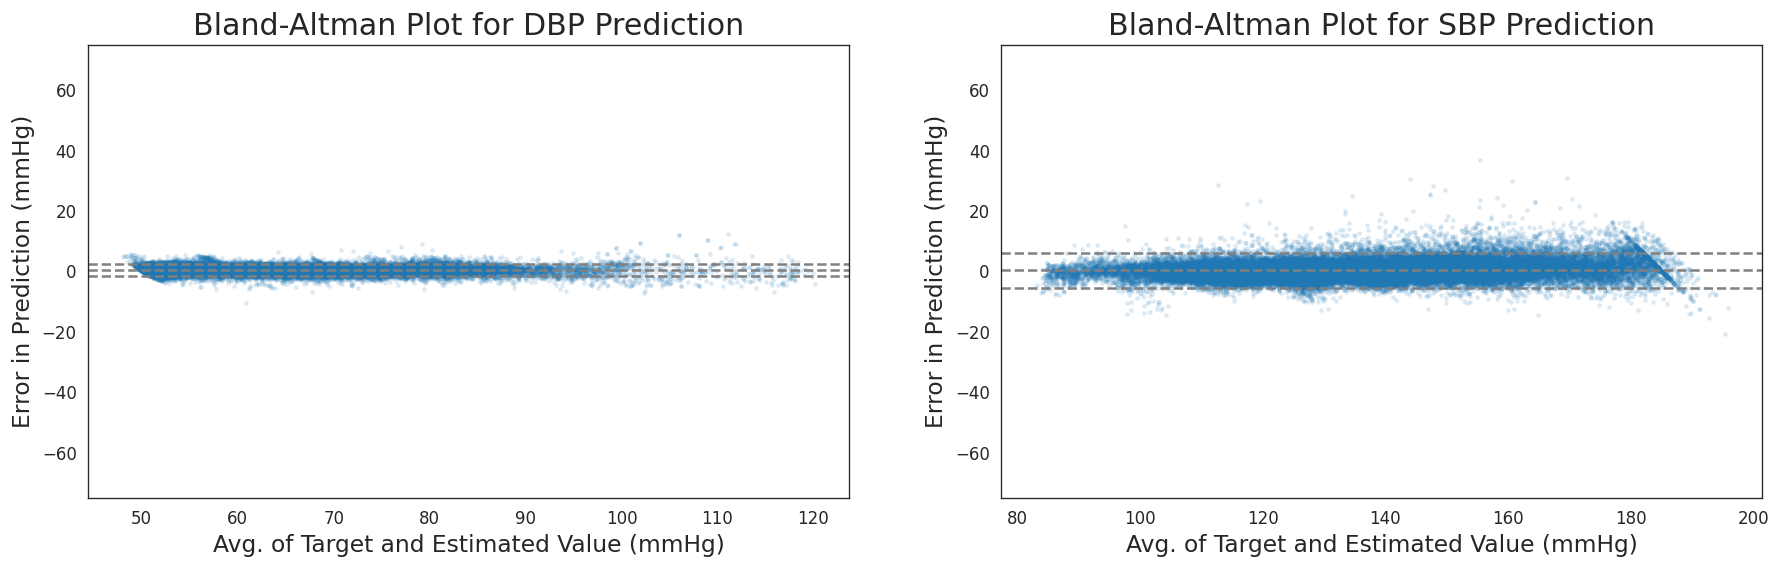

In [ ]:
bland_altman_plot_BP(SBP_Test, DBP_Test, Preds_SBP_PAVE2BP, Preds_DBP_PAVE2BP)

Text(0, 0.5, 'Density')

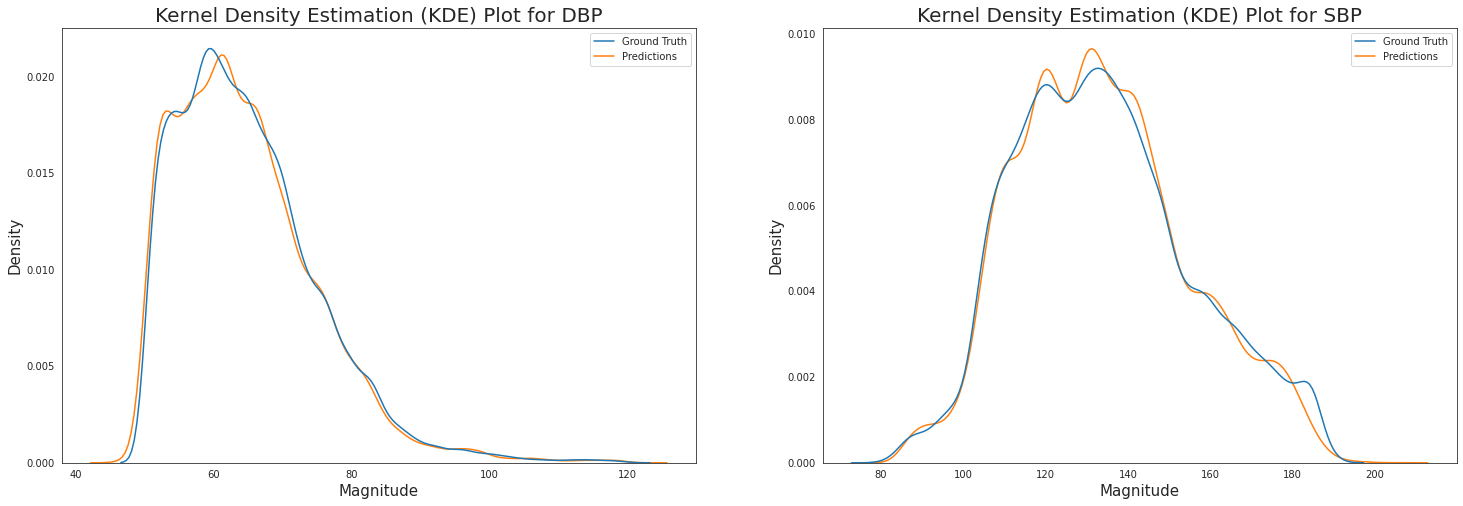

In [ ]:
df_DBP = pd.DataFrame(data = {'Ground Truth': DBP_Test.ravel(), 'Predictions': Preds_DBP_PAVE2BP.ravel()})
df_SBP = pd.DataFrame(data = {'Ground Truth': SBP_Test.ravel(), 'Predictions': Preds_SBP_PAVE2BP.ravel()})
plt.figure(figsize=(25,8))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_DBP)
plt.title('Kernel Density Estimation (KDE) Plot for DBP', fontsize=20)
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_SBP)
plt.title('Kernel Density Estimation (KDE) Plot for SBP', fontsize=20)
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel('Density', fontsize=15)

Text(0, 0.5, 'Magnitude')

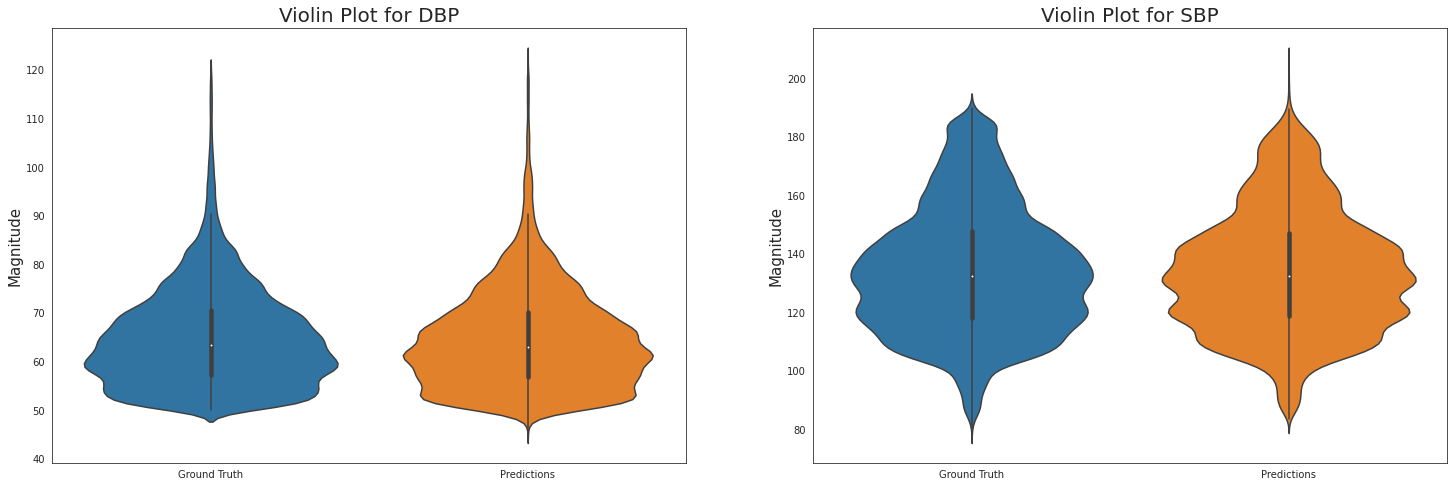

In [ ]:
df_DBP = pd.DataFrame(data = {'Ground Truth': DBP_Test.ravel(), 'Predictions': Preds_DBP_PAVE2BP.ravel()})
df_SBP = pd.DataFrame(data = {'Ground Truth': SBP_Test.ravel(), 'Predictions': Preds_SBP_PAVE2BP.ravel()})
plt.figure(figsize=(25,8))
plt.subplot(1, 2, 1)
sns.violinplot(data=df_DBP)
plt.title('Violin Plot for DBP', fontsize=20)
plt.ylabel('Magnitude', fontsize=15)
plt.subplot(1, 2, 2)
sns.violinplot(data=df_SBP)
plt.title('Violin Plot for SBP', fontsize=20)
plt.ylabel('Magnitude', fontsize=15)